In [21]:
import pandas as pd

data = pd.read_table('HiSeqV2.gz', index_col = 0)

print(data.shape)

print(data)

print(data.index)
print(data.columns)

(20530, 91)
           TCGA-KN-8419-01  TCGA-KL-8346-01  TCGA-KN-8422-01  TCGA-KN-8431-11  \
sample                                                                          
ARHGEF10L          10.1210          10.8281          10.6806          10.9231   
HIF3A               3.9466           3.1274           2.5779           7.3095   
RNF17               0.0000           0.0000           0.0000           0.0000   
RNF10              12.6677          13.0714          12.7034          12.3245   
RNF11              11.9200          11.3183          11.9008          11.5361   
...                    ...              ...              ...              ...   
PTRF               10.7475          10.5128          10.9949          11.9525   
BCL6B               9.4571           7.6066           7.5621           8.7045   
GSTK1              12.9376          12.5431          13.4927          11.7843   
SELP                6.5478           0.5159           5.2327           8.5058   
SELS            

In [22]:
# .loc – indexing using names of rows/columns
print(data.loc[:, 'TCGA-KN-8421-01'])

# if only a list given, then the first dimension of the table will be used (i.e., rows)
print(data.loc[['RNF17', 'ASS1', 'PLAA']])


# .iloc – indexing using indices
print(data.iloc[500:600:10, 5:15])

sample
ARHGEF10L    10.6903
HIF3A         4.2190
RNF17         0.0000
RNF10        12.4795
RNF11        11.4729
              ...   
PTRF         11.2243
BCL6B         5.4261
GSTK1        12.2734
SELP          2.8825
SELS         10.0914
Name: TCGA-KN-8421-01, Length: 20530, dtype: float64
        TCGA-KN-8419-01  TCGA-KL-8346-01  TCGA-KN-8422-01  TCGA-KN-8431-11  \
sample                                                                       
RNF17            0.0000           0.0000           0.0000           0.0000   
ASS1             6.4967           5.7402           6.5834          11.8778   
PLAA             9.7906           8.4248           9.9336           9.6004   

        TCGA-KN-8430-11  TCGA-KM-8440-01  TCGA-KO-8414-01  TCGA-KL-8323-01  \
sample                                                                       
RNF17            0.0000           0.0000           0.0000           0.0000   
ASS1             9.7493           5.5546           8.8178           7.7839   
PLAA  

In [23]:
# Names of samples: TCGA-KN-8430-11	   TCGA-KM-8440-01
#                              Normal             Case


condition = ['Normal' if int(i[-2]) else 'Tumor' for i in data.columns]

print('Total tumor samples: ', condition.count('Tumor'))
print('Total control samples: ', condition.count('Normal'))

# original data are log2(Expression level)
data = 2**data # log->normal

data_normal = data.loc[:, [True if int(i[-2]) else False for i in data.columns]]

data_tumor = data.loc[:, [False if int(i[-2]) else True for i in data.columns]]


Total tumor samples:  66
Total control samples:  25


In [24]:
data_normal_mean = data_normal.mean(axis = 1)
data_tumor_mean = data_tumor.mean(axis = 1)

import numpy as np
# log2(expression_case/expression_normal) = log2(case) – log2(norm)
logfc = np.log2(data_tumor_mean) - np.log2(data_normal_mean)

In [25]:
from scipy.stats import ttest_ind
# calculating the p-values for each gene
pvals = [ttest_ind(data_normal.values[i], data_tumor.values[i])[1] for i in range(data_normal.values.shape[0])]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
logfc_pvals = pd.DataFrame([logfc], index=['logFC']).T
logfc_pvals['pval'] = pvals

print(logfc_pvals)

              logFC          pval
sample                           
ARHGEF10L -0.378684  4.036111e-02
HIF3A     -2.941977  1.685664e-10
RNF17      0.292800  6.757021e-01
RNF10      0.329514  6.717684e-04
RNF11     -0.140920  3.673341e-02
...             ...           ...
PTRF      -1.165862  3.102272e-08
BCL6B     -0.708969  7.370060e-04
GSTK1      0.920430  3.508906e-08
SELP      -2.526249  2.507490e-24
SELS       0.521922  3.902880e-06

[20530 rows x 2 columns]


In [27]:
print(logfc_pvals.max())
print(logfc_pvals.min())

print('Genes with pval < 0.05: ', (logfc_pvals['pval'] < 0.05).sum())

logFC    9.422951
pval     0.999963
dtype: float64
logFC   -1.138065e+01
pval     4.663249e-50
dtype: float64
Genes with pval < 0.05:  12203


In [28]:
from statsmodels.stats.multitest import multipletests

logfc_pvals = logfc_pvals.fillna(1.0) # if all samples have the same expression, pval = NaN, changing NaN -> 1.0

pvals_corrected = multipletests(logfc_pvals.loc[:,'pval'].values, method = 'bonferroni')[1]

print('Genes with pval < 0.05 after FDR correction: ', (pvals_corrected < 0.05).sum())

logfc_pvals['pval_corr'] = pvals_corrected

logfc_pvals.sort_values('logFC', ascending=False)

Genes with pval < 0.05 after FDR correction:  5264


,logFC,pval,pval_corr
sample,,,
?|729884,9.422951,3.842713e-02,1.000000e+00
KLK4,8.805609,9.170257e-05,1.000000e+00
NKX6-1,8.695608,3.525921e-04,1.000000e+00
SCG3,8.678987,1.240367e-02,1.000000e+00
LHX9,8.496119,3.904716e-04,1.000000e+00
...,...,...,...
SLC22A6,-10.190225,7.514567e-06,1.542741e-01
ACSM2B,-10.248340,2.366526e-07,4.858477e-03
NPHS2,-10.385130,5.455516e-08,1.120017e-03


In [29]:
print('Top 25 up-regulated genes:')

logfc_pvals_sort = logfc_pvals.sort_values('logFC', ascending=False)
pval_filter = logfc_pvals.loc[:, 'pval_corr'] < 0.05
logfc_pvals_filtered = logfc_pvals_sort.loc[pval_filter]
top_25 = logfc_pvals_filtered[:25].index
print(' '.join(top_25))


print('Top 25 down-regulated genes:')
print(' '.join(logfc_pvals.sort_values('logFC', ascending=False).loc[logfc_pvals.loc[:, 'pval_corr'] < 0.05, :][-25:].index))

Top 25 up-regulated genes:
KLK15 C8orf71 ANO4 KLK3 LRRC14B CNTNAP5 HCN2 TRIM50 LRFN5 ATP2B2 SYNGR3 CYP11A1 TMC5 WBSCR17 NRXN3 PVALB FBN3 HS6ST3 GPR37 TNFAIP8L3 C15orf59 ST8SIA5 CLNK HAGHL TIMD4
Top 25 down-regulated genes:
CDHR5 DAO SLC6A19 DDC SLC34A1 SLC39A5 FABP1 HAO2 SLC9A3 SLC13A1 CLDN19 UGT2A3 AGXT2 UGT3A1 DPYS CALB1 ALDOB GLYAT PRODH2 SLC22A12 ACSM2A NAT8 ACSM2B NPHS2 AQP2


sample             KLK15 Condition   Gene
TCGA-KN-8419-01  10.8525     Tumor  KLK15
TCGA-KL-8346-01  10.0232     Tumor  KLK15
TCGA-KN-8422-01  10.5393     Tumor  KLK15
TCGA-KN-8431-11   2.0239    Normal  KLK15
TCGA-KN-8430-11   2.6119    Normal  KLK15
...                  ...       ...    ...
TCGA-KO-8408-01  10.0812     Tumor  KLK15
TCGA-KM-8443-01   9.3770     Tumor  KLK15
TCGA-KM-8442-01   7.2831     Tumor  KLK15
TCGA-KL-8332-11   2.4650    Normal  KLK15
TCGA-KL-8327-01   9.9300     Tumor  KLK15

[91 rows x 3 columns]


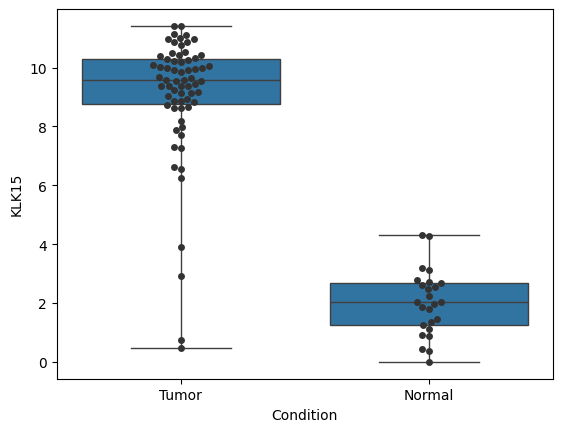

In [30]:
# Creating a table with Samples vs. Norm/Case
data = pd.read_table('HiSeqV2.gz', index_col = 0) # better for visualization
klk15 = data.loc[['KLK15'], :].T # original data are transposed
klk15['Condition'] = condition
klk15['Gene'] = 'KLK15'
print(klk15)

import seaborn as sns
ax = sns.boxplot(x="Condition", y='KLK15', data = klk15, whis=np.inf)
ax = sns.swarmplot(x="Condition", y='KLK15', data = klk15, color=".2")

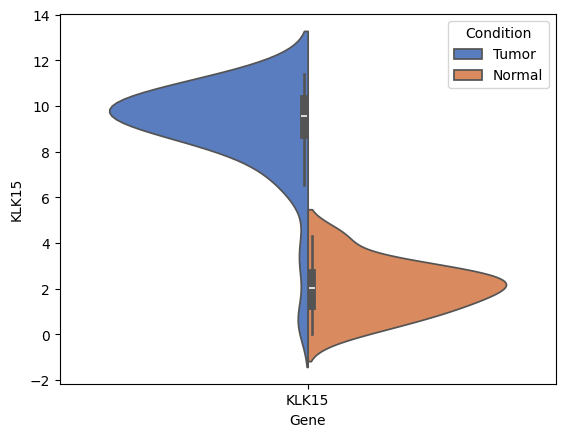

In [31]:
ax2 = sns.violinplot(x='Gene', y = 'KLK15', hue="Condition", data=klk15, palette="muted", split=True)

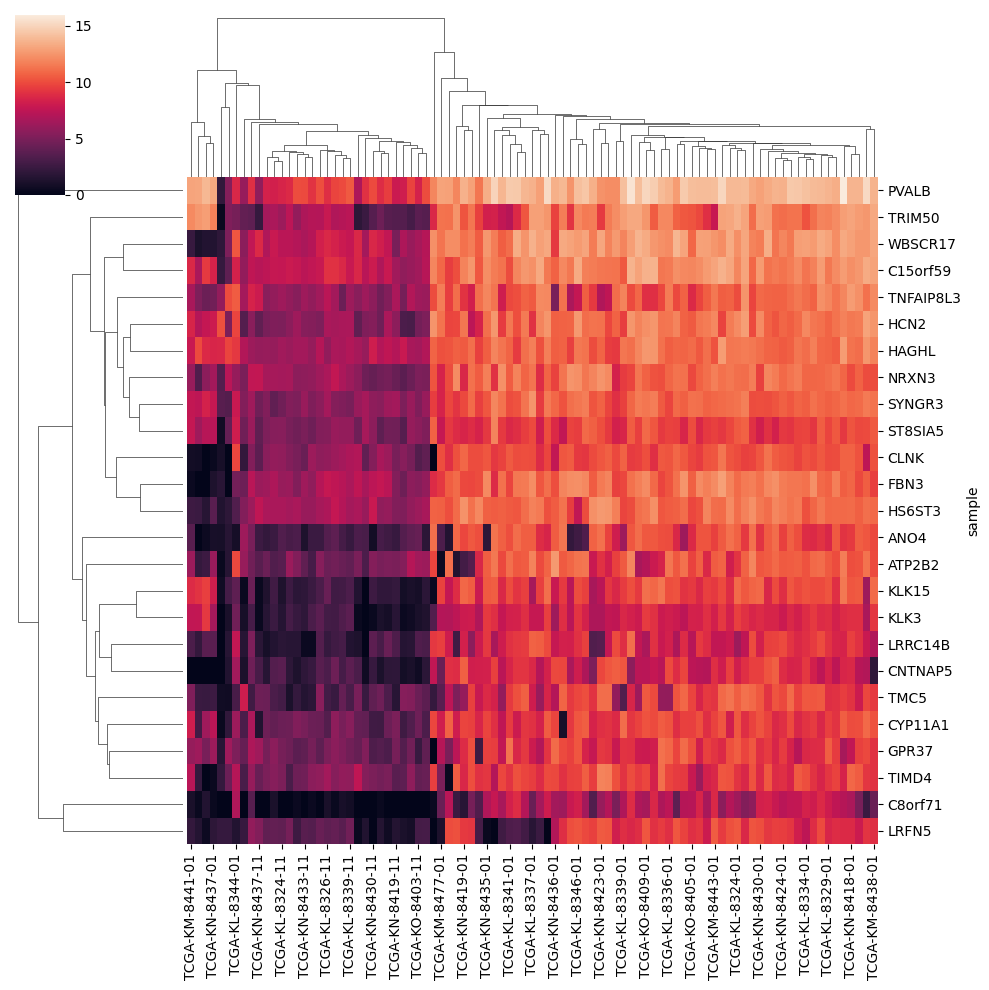

In [32]:
ax3 = sns.clustermap(data.loc[top_25])